In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IMPORTS

In [9]:
import os
from dotenv import load_dotenv

# data
import pandas as pd
import numpy as np

# src
from src.features.math import get_derivative
from src.general.io import to_pickle, from_pickle
from src.general.io import disable_warnings
from src.models.clustering import AffinityPropagationClustering, ClusteringMetricsCalculator, KMeansClustering, OPTICSClustering

In [10]:
disable_warnings()

# PATHS & NAMES

In [11]:
load_dotenv()

RAW_DATA_PATHS = {}
for short_name, filename in zip(["feb", "mar", "apr", "may", "feedback"],
                                ["event_stg_user_input_web_cw6.txt",
                                "event_stg_user_input_web_cw10.txt",
                                "event_stg_user_input_web_cw15.txt",
                                "event_stg_user_input_web_cw19.txt",
                                "current_user_feedback_text.xlsx",
                                ]):
    RAW_DATA_PATHS[short_name] = f"..{os.getenv('RAW_DATA_DIR')}/{filename}"


EXT_DATA_PATHS = {}
for short_name, filename in zip(["rasa"],
                                ["rasa_train_data.pkl"]):
    EXT_DATA_PATHS[short_name] = f"..{os.getenv('EXTERNAL_DATA_DIR')}/{filename}"


INTERIM_DATA_PATHS = {}
for short_name, filename in zip(["rasa_docs", "rasa_emb"],
                                ["rasa_docs.pkl",
                                "rasa_embedings.pkl",
                                ]):
    INTERIM_DATA_PATHS[short_name] = f"..{os.getenv('INTERIM_DATA_DIR')}/{filename}"

# add more interims
for short_name in RAW_DATA_PATHS.keys():
    INTERIM_DATA_PATHS[f"{short_name}_doc"] = f"..{os.getenv('INTERIM_DATA_DIR')}/{short_name}_docs.pkl"
    INTERIM_DATA_PATHS[f"{short_name}_emb"] = f"..{os.getenv('INTERIM_DATA_DIR')}/{short_name}_embeding.pkl"
    INTERIM_DATA_PATHS[f"{short_name}_tok"] = f"..{os.getenv('INTERIM_DATA_DIR')}/{short_name}_tokens.pkl"


EDA_REPORT_PATHS = {}
for short_name in RAW_DATA_PATHS.keys():
    EDA_REPORT_PATHS[short_name] = f"..{os.getenv('REPORT_DIR')}/eda_{short_name}.html"


KMEANS_PATH = f"..{os.getenv('MODELS_DIR')}/kmeans.pkl"

N_TOPICS = 20

In [12]:
# PROCESSED_FOLDER = "../data/processed"
# INTERIM_FOLDER = "../data/interim"
# REPORT_FOLDER = "../reports"
# MODELS_FOLDER = "../models"
# EXTERNAL_FOLDER = "../data/external"

# # processed
# FEEDBACK_PROCESSED_FILEPATH = f"{INTERIM_FOLDER}/feedback_docs.pkl"
# RASA_DOCS_FILEPATH = f"{INTERIM_FOLDER}/rasa_docs.pkl"
# RASA_EMBEDINGS_FILEPATH = f"{INTERIM_FOLDER}/rasa_embedings.pkl"
# RASA_FILEPATH = f"{EXTERNAL_FOLDER}/rasa_train_data.pkl"

# FEB_DOCS_FILEPATH = f"{INTERIM_FOLDER}/february_docs.pkl"
# APR_DOCS_FILEPATH = f"{INTERIM_FOLDER}/april_docs.pkl"
# MAY_DOCS_FILEPATH = f"{INTERIM_FOLDER}/may_docs.pkl"
# FEB_TOKENS_FILEPATH = f"{INTERIM_FOLDER}/february_tokens.pkl"
# APR_TOKENS_FILEPATH = f"{INTERIM_FOLDER}/april_tokens.pkl"
# MAY_TOKENS_FILEPATH = f"{INTERIM_FOLDER}/may_tokens.pkl"

# KMEANS_FILENAME = "kmeans.pkl"
# KMEANS_PATH = PROCESSED_FILEPATH = f"{MODELS_FOLDER}/{KMEANS_FILENAME}"


# N_TOPICS = 20

# DATA

In [15]:
docs = from_pickle(INTERIM_DATA_PATHS["feb_doc"])
tokens = from_pickle(INTERIM_DATA_PATHS["feb_tok"])

# Topic modelling

In [17]:
X = docs
len(X)

4791

In [7]:
mc = ClusteringMetricsCalculator()

### affinity

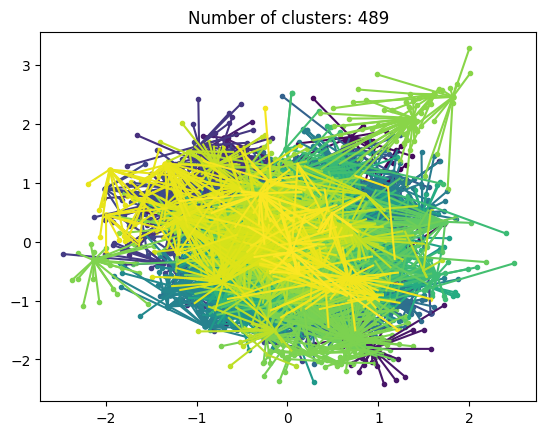

In [156]:
apc = AffinityPropagationClustering(seed=int(os.getenv('SEED')))
params = {
    'damping': 0.5,
    'max_iter': 250,
    'convergence_iter': 20,
    'preference': None,
    'affinity': 'euclidean'
}
apc.fit(X, params=params)
apc.plot_clusters()

# add metrics for comparison
mc.calculate_metrics(apc)

## K-Means

In [8]:
km = KMeansClustering(X, seed=int(os.getenv('SEED')))

In [9]:
# # Parametrizations
# min_clusters=50, max_clusters=200, step=25 # takes ~15 mins to train
# # cluster_list=[5, 10, 20, 40, 80, 160, 320] # takes ~3 mins to train
km.grid_search(min_clusters=10, max_clusters=200, step=20)
# to_pickle(km, KMEANS_PATH) # save if trained long model

100%|██████████| 10/10 [08:16<00:00, 49.63s/it]


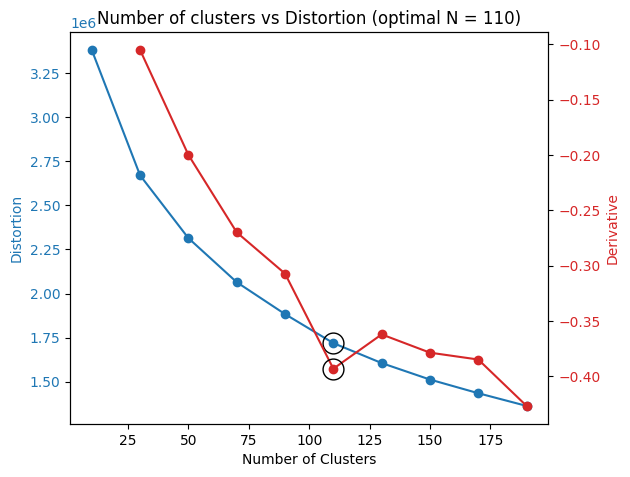

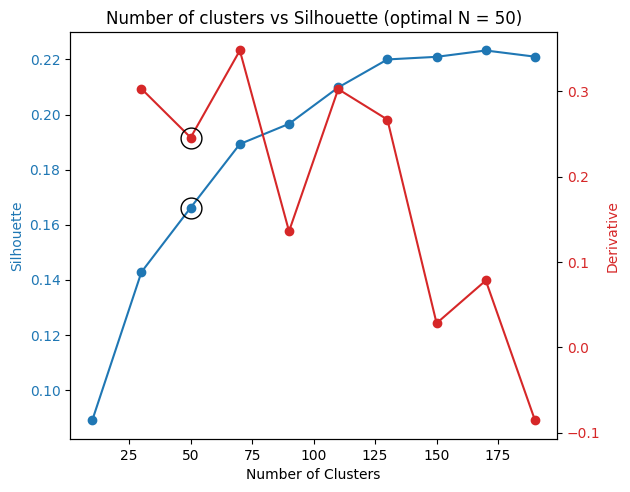

In [10]:
km.plot_elbow_graph("Distortion")
km.plot_elbow_graph("Silhouette")

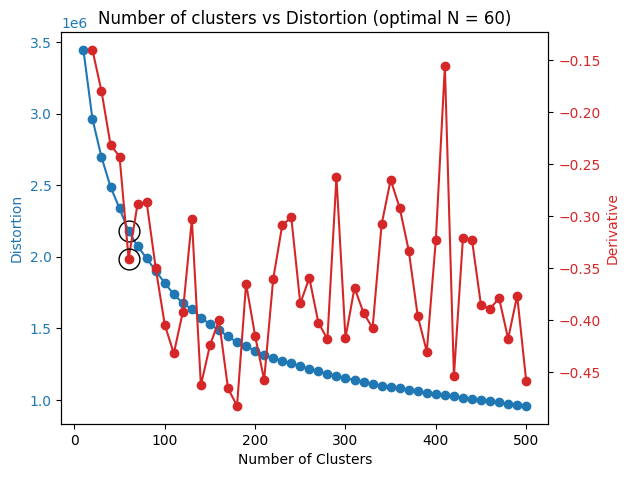

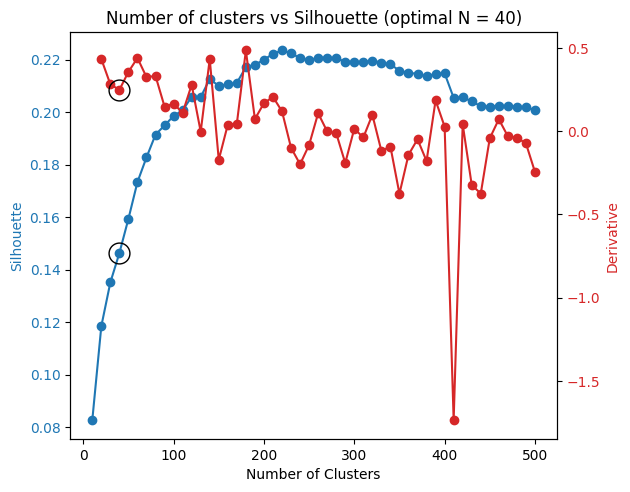

In [266]:
# km.plot_elbow_graph("Distortion")
# km.plot_elbow_graph("Silhouette")

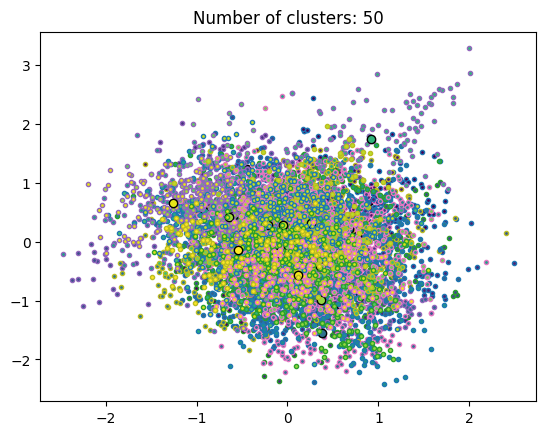

In [10]:
km.fit(n_clusters=50)
km.plot_clusters()
mc.calculate_metrics(km)

In [16]:
oc = OPTICSClustering(X) 
oc.fit(min_samples=100, max_eps=np.inf, metric='minkowski', p=2, cluster_method='xi') # 5 mins
mc.calculate_metrics(oc)

In [18]:
mc.get_metrics()

,KMeansClustering,OPTICSClustering
Silhouette Coefficient,0.17,-0.10
Calinski-Harabasz Index,143.10,12.92
Davies-Bouldin Index,2.10,1.35
Inertia,2314133.25,NaN
Distortion,NaN,NaN


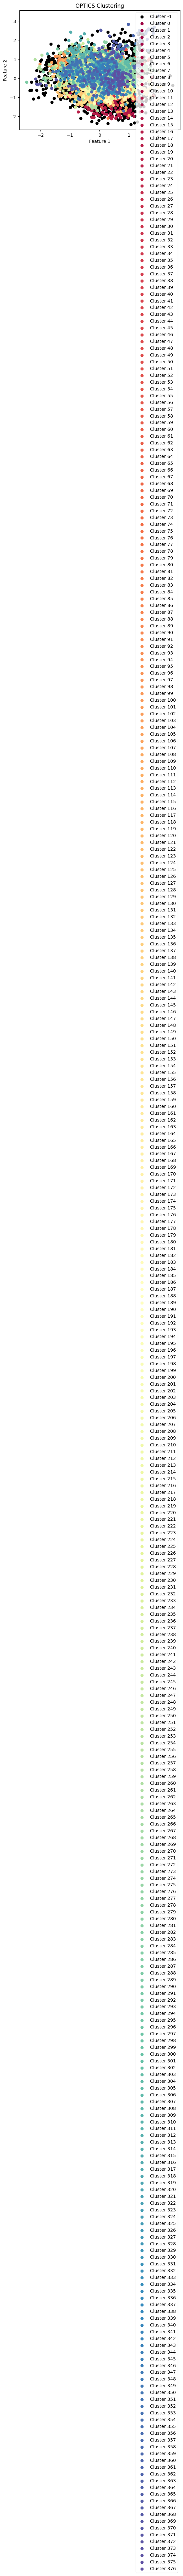

In [20]:
oc.plot_clusters(X)